# Welcome to my CS 444 Final Project

This notebook allows us to explore through the nucleus dataset and train UNet from scratch. 



In [1]:
# Activate Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Modules to import
import numpy as np
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt


#Exploring through dataset

## Transfer data to local drive

In [3]:
# Transport the dataset to the local disk
import shutil
from tqdm import tqdm
def transfer_data(in_path:str="", out_path:str="")->None:
  """}
  Transfer the data to the local - Also has loading bar for guestimate

  Keyword Argument:
  in_path (str) -- Input director of the data folder
  out_path (str) -- Output directory of the data folder

  Returns: None
  """

  # First listdir over the data folder to count number of folders in the directory (take out .csv)

  image_list = os.listdir(in_path)
  image_list = [s for s in image_list if not s.endswith('.csv')]

  # Delete folder if already exists
  if os.path.exists(out_path):
    shutil.rmtree(out_path)
  
  os.mkdir(out_path)

  # Run tqdm forloop
  for i in tqdm(range(len(image_list))):
    shutil.copytree(os.path.join(in_path,image_list[i]),os.path.join(out_path,image_list[i]))
  
  return None


In [4]:
transfer_data(in_path = "/content/drive/MyDrive/041921-UNet/data", out_path = "/content/data")

100%|██████████| 670/670 [05:07<00:00,  2.18it/s]


## Visualization

### Define read_image wrapper

In [5]:
# Define function for reading image
def read_image(image_path:str = ""):
    """
    Wrapper function to read image and raw image
    """


    I = plt.imread(os.path.join(image_path,'image.png'))
    M = (plt.imread(os.path.join(image_path,'mask.png'))[:,:,0]>0)

    return I,M

### Visualize Data before cropping

Text(0.5, 0.98, 'Dataset Examples before cropping')

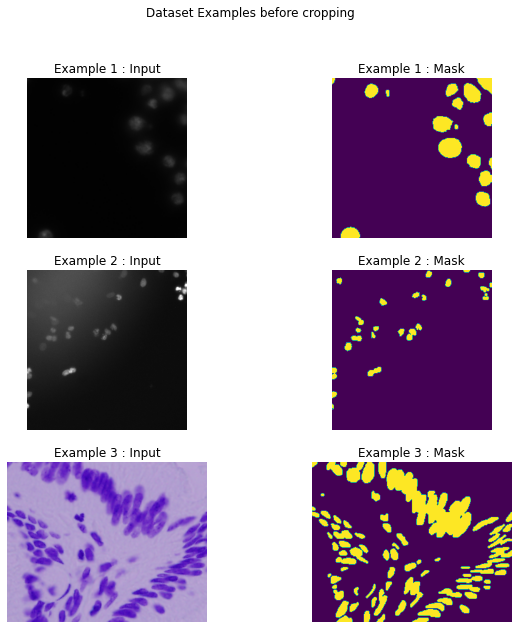

In [6]:
# Visualize few dataset
data_path = '/content/drive/MyDrive/041921-UNet/data'

# read csv and random sample 3 examples from the list
df = pd.read_csv(os.path.join(data_path,'nucleus_df.csv'))
df_sample = df.sample(n = 3, random_state=0)

# Visualize
plt.figure(figsize = (10,10))

for i in range(3):

  I,M = read_image(os.path.join("/content/data",df['0'].iloc[i]))
  
  idx = i*2 + 1
  plt.subplot(3,2,2*i+1)
  plt.imshow(I)
  plt.axis('off')
  plt.title(f'Example {i+1} : Input')

  plt.subplot(3,2,2*i+2)
  plt.imshow(M)
  plt.axis('off')
  plt.title(f'Example {i+1} : Mask')

plt.suptitle('Dataset Examples before cropping')

#print(df['0'].iloc[0])

Here we realize that the dataset consists of images of various size and some images have BW color where as some have full RGB features. However, the datasets are saved in RGBA format regardless of which type of image. 

The difference in size can be overcome using two methods:

1. Resize the images to a constant dimension (N,M)

2. Crop the image to a constant dimension (A,B)

We will take the latter option due to aspect ratio being difference - We want to take it safe!

### Visualize image dataset with cropping

In [7]:
# Define center crop function
def c_crop(I:np.ndarray = None, sz:tuple = (200,200)):
  """
  Center crop function for np.array 
  We wont need this for machine learning section (just for vis)

  Keyword Arguments:
  I(np.ndarray) -- Input image
  sz(tuple) -- size for cropping (length 2)
  """

  sz_I = np.shape(I)
  cx,cy = sz_I[1]//2,sz_I[0]//2
  sx,sy = sz[1],sz[0]

  if len(sz_I) == 2:
    return I[cy-sy//2:cy+sy//2, cx-sx//2:cx+sx//2]

  elif len(sz_I) == 3:
    return I[cy-sy//2:cy+sy//2, cx-sx//2:cx+sx//2,:]

  else:
    ValueError('Wrong dimmension for cropping...')



Text(0.5, 0.98, 'Dataset Examples after cropping')

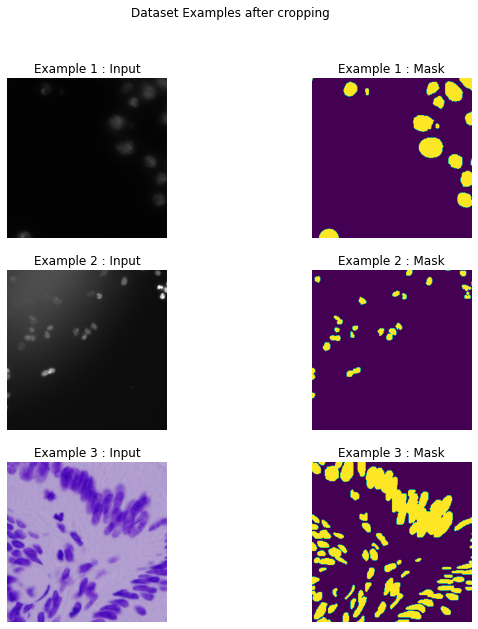

In [8]:
# Visualize few dataset
data_path = '/content/drive/MyDrive/041921-UNet/data'

# Cropping parameters 
sz = (250,250)

# read csv and random sample 3 examples from the list
df = pd.read_csv(os.path.join(data_path,'nucleus_df.csv'))
df_sample = df.sample(n = 3, random_state=0)

# Visualize
plt.figure(figsize = (10,10))

for i in range(3):

  I,M = read_image(os.path.join("/content/data",df['0'].iloc[i]))
  
  
  idx = i*2 + 1
  plt.subplot(3,2,2*i+1)
  plt.imshow(c_crop(I = I , sz = sz))
  plt.axis('off')
  plt.title(f'Example {i+1} : Input')

  plt.subplot(3,2,2*i+2)
  plt.imshow(c_crop(I = M, sz = sz))
  plt.axis('off')
  plt.title(f'Example {i+1} : Mask')

plt.suptitle('Dataset Examples after cropping')

We do realize for the 3rd example that the features toward the edge are completely removed. Although we do know if there no cells, the cells should not be highlighted, empty frames may/may not get in the way of the training. I removed them for safety

# Training Prep

Here, we want to define the dataset, dataloader, loss, evaluation metrics and lastly the model before training our U-Net

## Dataset and Dataloader

### Dataset Defintion

In [9]:
# Dataset definition

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

class cell_dataset(Dataset):
  """
  Cell dataset class for fetch and process

  Class attributes:
  __init__ -- Constructor
  __len__ -- Returns number of examples in the dataset
  __getitem__ -- Fetches single example
  """

  def __init__(self, image_dir:str = '', df:pd.DataFrame = None, transform = None):
    """
    Constructor for dataset class 

    Keyword arguments:
      image_dir(str) -- base directory of the image
      df(pd.DataFrame) -- dataframe object containing folder names
      transform(transforms) -- transformations used for the dataset
    
    Returns : None
    """

    self.image_dir = image_dir
    self.folders = df
    self.transform = transform

  def __len__(self):
    """
    Returns length of the folder list
    """

    return len(self.folders)
  
  def __getitem__(self,idx):
    """
    Returns I,M which are the fetched input and corresponding mask

    Keyword arguments:
      idx -- index used for the folderlist
    
    Returns:
      I_trans -- Input image transformed
      M_trans -- Corresponding mask transformed
    """

    folder_name = self.folders['0'].iloc[idx]

    I,M = read_image(os.path.join(self.image_dir, folder_name))
    I = I*255
    M = M*255
    # Transform image and mask as necessary
    I_trans = self.transform(I.astype(np.uint8))
    M_trans = self.transform(M.astype(np.uint8))
    # Return the dataset

    return I_trans.to(torch.float32), M_trans.to(torch.float32)

### Distribution of dataset into train, val, and test loader

In [10]:
# Define transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    ])

# Define dataset
data_path = "/content/data"
full_dataset = cell_dataset(data_path, df, transform)

# random_split ratio
rtrain = 0.7; rval = 0.2

#batch_size
batch_size = 20

# ratio to count
Ntrain = int(rtrain * full_dataset.__len__())
Nval = int(rval * full_dataset.__len__())
Ntest = full_dataset.__len__() - Ntrain - Nval

# partition
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [Ntrain, Nval, Ntest])

# Make dataloaders 
train_loader = DataLoader(train_dataset, shuffle = True, drop_last = False, batch_size = batch_size)
val_loader = DataLoader(val_dataset, shuffle = True, drop_last = False, batch_size = batch_size)
test_loader = DataLoader(test_dataset, shuffle = False, drop_last = False, batch_size = 1)

## Define Loss function used

In [11]:
# Binary cross entropy
import torch.nn as nn
loss_function = nn.BCELoss() # BCE loss

## Evaluation metrics

In this section, we will define the function to evaluate the confusion matrix for each thresholding we use against the sigmoid to make the decision. 

The confusion matrix will consist of the following factors ...



1.   True Positive : TP
2.   True Negative (which is background so we don't care)
3.   False Positive : FP
4.   False Negative : FN

Using the confusion matrix metrics, we can define the True positive rate rTP and False positive rate rFP as the following

rTP = TP/(TP + FN) \
rFP = FP/(FP + TN)


Using these informations, we will use the ROC curve (Receiver Operating Characteristics curve) to evaluate the model's ability to correctly classify the foreground from the background. ROC curve is simply plotting of rTP and rFP with difference values of threshold. 

We use this metric to do the following 

1.  Evaluate AUC (area under curve) to determine how the model in general performs in binary segmentation task
2.  Find the optimal threshold value






### Image-wise Confusion matrix function

In [12]:
def conf_matrix(Target:torch.Tensor = None, Pred:torch.Tensor = None, num_thresholds:int = 30):
  """
  Evaluates single image pair confusion matrix returned as a dictionary for each threshold value

  Keyword arguments:
    Target(torch.Tensor) -- Target groundtruth map
    Pred(torch.Tensor) -- Prediction map after sigmoid
    num_thresholds(int) -- Number of values of thresholds to try (default: 30)

  Return arguments:
    cmatrix(dictionary) -- Dictionary of confusion matrix output for each threshold value
                            "TP" -- True Positive count with length = Num_thresholds
                            "FP" -- False Positive count with length = Num_thresholds
                            "FN" -- False Negative count with length = Num_thresholds
                            "TN" -- True Negative count with length = Num_thresholds
                            "th" -- Threshold values tried
                            ""
  """


  # Make an array of threshold values between 0,1 (exclusive)

  th = np.linspace(start = 0, stop = 1, num=num_thresholds, endpoint = False)

  # Initiate variables
  tp = np.zeros_like(th)
  fp = np.zeros_like(th)
  fn = np.zeros_like(th)
  tn = np.zeros_like(th)

  # Create a loop over threshold values to evaluate the three parameters necessary

  for i, threshold in enumerate(th):
      # Modify the prediction array to boolean based on current threshold
      Pred_th = Pred > threshold
      Target_th = Target > threshold

      # Evaluate TP based on simply bitwise and and sum the result 
      tp[i] = torch.sum(torch.bitwise_and(Pred_th,Target_th))

      # Evaluate FP based on bitwise and and sum of ~GT and PR
      fp[i] = torch.sum(torch.bitwise_and(Pred_th,~Target_th))

      # Evaluate FN based on bitwise and and sum of GT and ~PR
      fn[i] = torch.sum(torch.bitwise_and(~Pred_th,Target_th))

      # Evaluate TN based on bitwise and of ~GT and ~PR
      tn[i] = torch.sum(torch.bitwise_and(~Pred_th, ~Target_th))

  # Return the output as a dictionary
  cmatrix = {
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn,
        "th": th
  }

  return cmatrix


In [13]:
# For testing

A = torch.rand((50,50))
B = torch.rand((50,50))

d = conf_matrix(A,B,10)

print(d['TP'])
print(d['FP'])
print(d['FN'])
print(d['TN'])
print(d['th'])


[2500. 2010. 1611. 1236.  944.  650.  390.  223.  102.   19.]
[  0. 232. 393. 507. 572. 618. 617. 554. 413. 226.]
[  0. 239. 392. 527. 593. 626. 605. 527. 378. 220.]
[   0.   19.  104.  230.  391.  606.  888. 1196. 1607. 2035.]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


### ROC Curve definition

In [14]:
def roc_plot(cm = None):
    """
    Plot ROC curve and returns the arrays (threshold, rFP, rTP) as dictionary

    Keyword arguments:
      cm (dict) -- Dictionary input from the conf_matrix function
    
    Returns:
      roc_data (dict) -- ROC dictionary consisting of...
                         thresholds -- array of thresholds
                         rFP -- false positive rates
                         rTP -- true positive rates
      AUC (float) -- Area under ROC curve
    """

    # Unpack from dictionary
    tp = cm["TP"]
    fp = cm["FP"]
    fn = cm["FN"]
    tn = cm["TN"]
    th = cm["th"]

    # Evaluate the rTP and rFP
    rTP = tp/(tp+fn)
    rFP = fp/(fp+tn)

    # Filter nan out
    rTP[np.isnan(rTP)] = 0
    rFP[np.isnan(rFP)] = 1

    # plot the roc curves
    plt.figure()
    plt.plot(rFP, rTP)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")

    # return the roc_data and AUC
    roc_data = {
          "thresholds": th,
          "rTP": rTP,
          "rFP": rFP
    }
    AUC = np.trapz(np.flip(rTP), np.flip(rFP))

    return roc_data, AUC

0.4930944445221623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


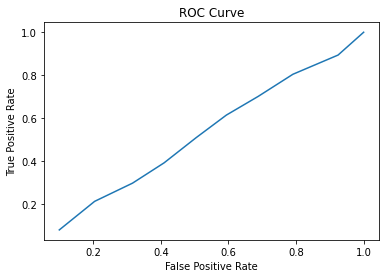

In [15]:
# Test code for random classification
roc_data, AUC = roc_plot(d)
print(AUC)

## Training environment

### Training function

In [16]:
# Train script

from operator import xor
from sklearn.metrics import f1_score

# Training script...
def train(model = None, device = 'cuda', optimizer = None, train_loader = None, val_loader = None, num_epochs = 10, batch_size = 1, lr = 1e-4):
  """
  Training script

  Keyword argument:
    model(nn.Module) -- Network
    device(str) -- cuda by default
    optimizer -- optimizer for training
    train_loader -- train dataloader for training
    val_loader -- validation dataloader for training
    num_epochs -- number of epochs trained for
    batch_size -- number of examples per batch
    lr -- learning rate

  Returns:
    train_output -- Dictionary for train output
  """

  # Epoch loss to return
  t_train_loss = []
  t_val_loss = []
  
  # Criterion
  criterion = nn.BCELoss()

  # Epoch loop
  for t in range(num_epochs):
    print(f"------------epoch{t+1}--------------")
    model.train() # train mode
    b_train_loss = [] # batch_loss for training
    b_val_loss = [] # batch_loss for validation

    # Batch loop
    for x,y in tqdm(train_loader):
      # zero_gradient
      optimizer.zero_grad()

      # Prediction over input images
      p = model(x.to(device))

      # Evaluate bce loss
      loss = criterion(p,y.to(device))

      # Backprop
      loss.backward()
      optimizer.step()

      # Append to b_train_loss (batch)
      b_train_loss.append(loss.item())

    # Evaluation over validation set
    model.eval()
    with torch.no_grad():
      for _x,_y in val_loader:
        

        # forward pass
        _p = model(_x.to(device))

        # evaluate bce loss
        loss = criterion(_p, _y.to(device))

        # append to b_val_loss (batch)
        b_val_loss.append(loss.item())

    # Save the losses to t_val/t_train loss
    t_train_loss.append(np.mean(b_train_loss))
    t_val_loss.append(np.mean(b_val_loss))

    # Print out the validation loss
    print(f'===> Epoch {t+1}: Train Loss -> {t_train_loss[-1]}')
    print(f'===> Epoch {t+1}: Validation Loss -> {t_val_loss[-1]}')

  # Return dictionary as needed
  return {
        'train_loss':t_train_loss,
        'val_loss':t_val_loss
  }





### The network components

In [17]:
import torch
import torch.nn as nn
import numpy as np


class DoubleConv(nn.Module):
    """DoubleConv layer inherited from nn.Module

    Class attributes:
    __init__ -- Constructor for layer
    forward -- Forward pass through the model
    """

    def __init__(self, in_channels:int = 1, out_channels:int = 1, kernel_size:int = 3) -> None:
        """ Constructor for DoubleConv

        Keyword arguments:
        in_channels -- Number of filters for input (default 1)
        out_channels -- Number of filters for output (default 1)

        Returns:
        None
        """
        
        super(DoubleConv,self).__init__()

        # Double convolution defined with nn.Sequential of ordered layer dictionary
        self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels = in_channels, out_channels=out_channels, kernel_size = kernel_size, padding = 'same'),
                nn.BatchNorm2d(num_features = out_channels),
                nn.ReLU(inplace = True),
                nn.Conv2d(in_channels = out_channels, out_channels=out_channels, kernel_size = kernel_size, padding = 'same'),
                nn.BatchNorm2d(num_features = out_channels),
                nn.ReLU(inplace = True)
        )
                
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Forward operation

        Keyword arguments:
        x -- Input Torch tensor (default None)

        Returns:
        y -- Layer output
        """

        y = self.double_conv(x)
        return y

class OutConv(nn.Module):
    """ Output convolution layer

    Class attributes:
    __init__ -- Constructor for layer
    forward -- Forward pass through the model
    """

    def __init__(self, in_channels = 1, out_channels = 1, kernel_size = 3):
        """ Constructor for OutConv

        Keyword arguments:
        in_channels -- Number of filters for input (default 1)
        out_channels -- Number of filters for output (default 1)
        kernel_size -- Convolution kernel size (default 3)

        Returns:
        None
        """
        super(OutConv,self).__init__()

        self.out_conv = nn.Sequential(
                nn.Conv2d(in_channels = in_channels, out_channels=out_channels, kernel_size = kernel_size, padding = 'same'),
                nn.Sigmoid()
        )

    
    def forward(self, x: torch.Tensor = None, x_skip: torch.Tensor = None):
        """ Forward operation for Outconv

        Keyword arguments:
        x -- Input image for forward propagation (default None)
        x_skip -- Input image for skip connection which can be set to None if unwanted (default None)

        Returns:
        y -- Output pixel-wise probability 
        """


        # Apply out conv 
        y = self.out_conv(x)

        return y

class Decoder(nn.Module):
    """ Decoder operation (Double conv followed by whichever upsampling operation needed)

    Class attributes:
    __init__ -- Constructor for layer
    forward -- Forward pass through the model
    """

    def __init__(self, in_channels:int = 1, out_channels:int = 1, kernel_size:int = 3, mode = 'bilinear'):
        """ Constructor for Decoder
        
        Keyword arguments 
        in_channels -- Number of filters for input (default 1)
        out_channels -- Number of filters for output (default 1)
        kernel_size -- Convolution kernel size (default 3)
        mode -- Mode used for upsampling (default 'bilinear')
        
        Returns
        None
        """
        super(Decoder,self).__init__()

        # Double conv block
        self.double_conv = DoubleConv(in_channels = in_channels, out_channels=out_channels, kernel_size = kernel_size)
        
        # Conditional assignment

        if mode == "conv":
            self.up_sampler = nn.Sequential(nn.ConvTranspose2d(kernel_size = 2,
                                                 in_channels = in_channels,
                                                 out_channels = out_channels,
                                                 stride = 2,
                    ))
        
        elif mode == "bilinear" or mode == "bicubic":
            self.up_sampler = nn.Sequential(
                    nn.Upsample(scale_factor = 2, mode = mode),
                    nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, padding = 'same')
            )
        
        
        else:
            raise ValueError('Wrong modes', mode)
        
    
    def forward(self, x:torch.Tensor = None, x_skip:torch.Tensor = None):
        """ forward for the decoder block

        Keyword arguments
        x -- Input tensor (default None)
        x_skip -- Input tensor from skip connection

        Returns
        y -- Ouput from the decoder
        """

        # Upsampling block
        x = self.up_sampler(x)

        # Skip connection only when needed
        if x_skip is not None:
            # evaluate size difference in x and y and pad by half the difference each side
            del_x = abs(x.size()[-1]-x_skip.size()[-1]) ; del_y = abs(x.size()[-2]-x_skip.size()[-2]) 
            
            # padding
            x = nn.functional.pad(x, [del_x // 2, del_x - del_x // 2, del_y // 2, del_y - del_y // 2])

            # Concatenate two feature maps
            x = torch.cat([x_skip,x],dim=1)

        # Double Conv    
        y = self.double_conv(x)

        return y

class Encoder(nn.Module):
    """ Encoder implementation 

    Class attributes:
    __init__ -- Constructor for layer
    forward -- Forward pass through the model
    """

    def __init__(self, in_channels:int = 1, out_channels:int = 1, kernel_size:int = 3, mode:str = 'max'):
        """ Constructor for Encoder

        Keyword arguments
        in_channels -- Number of filters for input (default 1)
        out_channels -- Number of filters for output (default 1)
        kernel_size -- Convolution kernel size (default 3)

        Returns -- None
        """

        super(Encoder,self).__init__()

        # Double Conv
        self.double_conv = DoubleConv(in_channels = in_channels, out_channels=out_channels, kernel_size = kernel_size)

        # Downsampling using conditional assignment
        if mode == 'max':
            self.pool = nn.Sequential(
                    nn.MaxPool2d(kernel_size = 2, stride = 2)
            )
        
        elif mode == 'avg':
            self.pool = nn.Sequential(
                    nn.AvgPool2d(kernel_size = 2, stride = 2)
            )
        
        else:
            raise ValueError('Invalid mode for pooling', mode)

    def forward(self, x):
        """ Forward propagation through encoder

        Keyword argument
        x -- Input feature for the encoder
        
        Returns 
    
        outputs -- Dictionary consisting of The full output and Intermediate 
                   output feature map before pooling used for skip connection
        """
        
        # Double convolution
        x_skip = self.double_conv(x)
        
        # Pooling
        y = self.pool(x_skip)

        # Define dictionary for output
      
        return y,x_skip
        
class BottleNeck(nn.Module):

    """ BottleNeck block for bottom of U-Net

    Class attributes
    __init__ -- Constructor for layer
    forward -- Forward pass through the model
    """

    def __init__(self, in_channels:int = 1, out_channels:int=1, kernel_size:int = 3):
        """ Constructor for bottleNeck block

        Keyword arguments
        in_channels -- Number of filters for input (default 1)
        out_channels -- Number of filters for output (default 1)
        kernel_size -- Convolution kernel size (default 3)
        """

        super(BottleNeck,self).__init__()

        # Double conv
        self.double_conv = DoubleConv(in_channels = in_channels, out_channels=out_channels, kernel_size = kernel_size)

    def forward(self, x):
        """
        Keyword argument
        x -- Input feature for the encoder
        
        Returns
        y -- Output from the BottleNeck into the decoder
        """

        y = self.double_conv(x)

        return y



### UNet Model

In [18]:

class UNet(nn.Module):
    """ Unet network 

    Class attributes:
    __init__ -- Constructor for layer
    forward -- Forward pass through the model
    """

    def __init__(self, in_channels:int = 3, num_labels:int = 1, base_num_filters:int = 32, mode:str = 'bilinear'):
        """ Constructor for UNet

        Keyword arguments:
        in_channels -- Number of channels in input image (Default 3 for RGB)
        num_labels -- Number of labels in the output image (Default 1 for binary)
        base_num_filters -- Number of intiial filer after input conv (Default 32)
        mode -- Mode of upsampling

        Returns: 
        None
        """

        super(UNet,self).__init__()
        self.encoder1 = Encoder(in_channels = in_channels, out_channels = base_num_filters, kernel_size = 3, mode = 'max')
        self.encoder2 = Encoder(in_channels = base_num_filters, out_channels = base_num_filters*2, kernel_size = 3, mode = 'max')
        self.encoder3 = Encoder(in_channels = base_num_filters*2, out_channels = base_num_filters*4, kernel_size = 3, mode = 'max')
        self.encoder4 = Encoder(in_channels = base_num_filters*4, out_channels = base_num_filters*8, kernel_size = 3, mode = 'max')

        self.bottle_neck = BottleNeck(in_channels = base_num_filters*8, out_channels = base_num_filters*16, kernel_size = 3)
        
        self.decoder1 = Decoder(in_channels = base_num_filters*16, out_channels = base_num_filters*8, kernel_size = 3, mode = mode)
        self.decoder2 = Decoder(in_channels = base_num_filters*8, out_channels = base_num_filters*4, kernel_size = 3, mode = mode)
        self.decoder3 = Decoder(in_channels = base_num_filters*4, out_channels = base_num_filters*2, kernel_size = 3, mode = mode)
        self.decoder4 = Decoder(in_channels = base_num_filters*2, out_channels = base_num_filters*1, kernel_size = 3, mode = mode)

        self.out_conv = OutConv(in_channels = base_num_filters, out_channels = num_labels, kernel_size = 3)

# -------------- U Net Blocks --------------

    def forward(self, x):
      """ forward operation for the UNet
      
      Keyword argument:
      x -- Input image

      Returns
      y -- Output probability map
      """

      e1,s1 = self.encoder1(x)
      e2,s2 = self.encoder2(e1)
      e3,s3 = self.encoder3(e2)
      e4,s4 = self.encoder4(e3)

      b = self.bottle_neck(e4)

      d1 = self.decoder1(b,s4)
      d2 = self.decoder2(d1,s3)
      d3 = self.decoder3(d2,s2)
      d4 = self.decoder4(d3,s1)

      y = self.out_conv(d4) # Has sigmoid
      
      return y

## Run training (Transposed Conv)

In [19]:
import torch.optim as optim

device = 'cuda'
model = UNet(in_channels = 4, num_labels = 1, base_num_filters=16, mode = 'conv').to(device)
lr = 1e-4
optimizer = optim.Adam(model.parameters(),lr=lr)
torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=2)
num_epochs = 60
batch_size = 50


params = train(model = model, device = 'cuda', optimizer = optimizer, train_loader= train_loader, val_loader = val_loader, num_epochs = num_epochs,batch_size = batch_size, lr = lr)


------------epoch1--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 1: Train Loss -> 0.6153448422749838
===> Epoch 1: Validation Loss -> 0.6431927680969238
------------epoch2--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 2: Train Loss -> 0.5036277162532011
===> Epoch 2: Validation Loss -> 0.5053284295967647
------------epoch3--------------


100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


===> Epoch 3: Train Loss -> 0.4389293007552624
===> Epoch 3: Validation Loss -> 0.4063674807548523
------------epoch4--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 4: Train Loss -> 0.3863063342869282
===> Epoch 4: Validation Loss -> 0.34845117160252165
------------epoch5--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 5: Train Loss -> 0.3547395219405492
===> Epoch 5: Validation Loss -> 0.31298849412373136
------------epoch6--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 6: Train Loss -> 0.3082759405175845
===> Epoch 6: Validation Loss -> 0.2910947799682617
------------epoch7--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 7: Train Loss -> 0.27515190839767456
===> Epoch 7: Validation Loss -> 0.2679107529776437
------------epoch8--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 8: Train Loss -> 0.2475682863344749
===> Epoch 8: Validation Loss -> 0.21791566056864603
------------epoch9--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 9: Train Loss -> 0.22987059814234576
===> Epoch 9: Validation Loss -> 0.2057452223130635
------------epoch10--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 10: Train Loss -> 0.20283948133389154
===> Epoch 10: Validation Loss -> 0.1814738873924528
------------epoch11--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 11: Train Loss -> 0.187964524452885
===> Epoch 11: Validation Loss -> 0.16202738881111145
------------epoch12--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 12: Train Loss -> 0.17378023949762186
===> Epoch 12: Validation Loss -> 0.15571101435593196
------------epoch13--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 13: Train Loss -> 0.1617187224328518
===> Epoch 13: Validation Loss -> 0.14534605613776616
------------epoch14--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 14: Train Loss -> 0.1500947866588831
===> Epoch 14: Validation Loss -> 0.13828473538160324
------------epoch15--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 15: Train Loss -> 0.14233221113681793
===> Epoch 15: Validation Loss -> 0.12837924382516316
------------epoch16--------------


100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


===> Epoch 16: Train Loss -> 0.13648993770281473
===> Epoch 16: Validation Loss -> 0.1160631531051227
------------epoch17--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 17: Train Loss -> 0.12812252808362246
===> Epoch 17: Validation Loss -> 0.11493890306779317
------------epoch18--------------


100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


===> Epoch 18: Train Loss -> 0.12526862509548664
===> Epoch 18: Validation Loss -> 0.1144885431442942
------------epoch19--------------


100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


===> Epoch 19: Train Loss -> 0.12152692458281915
===> Epoch 19: Validation Loss -> 0.10646564194134303
------------epoch20--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 20: Train Loss -> 0.11759113147854805
===> Epoch 20: Validation Loss -> 0.09853256919554301
------------epoch21--------------


100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


===> Epoch 21: Train Loss -> 0.10937486371646325
===> Epoch 21: Validation Loss -> 0.09504614557538714
------------epoch22--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 22: Train Loss -> 0.10543994698673487
===> Epoch 22: Validation Loss -> 0.09148867002555303
------------epoch23--------------


100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


===> Epoch 23: Train Loss -> 0.10224753804504871
===> Epoch 23: Validation Loss -> 0.0912739560008049
------------epoch24--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 24: Train Loss -> 0.09853365241239469
===> Epoch 24: Validation Loss -> 0.08953723630734853
------------epoch25--------------


100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


===> Epoch 25: Train Loss -> 0.0958736368144552
===> Epoch 25: Validation Loss -> 0.0869908274284431
------------epoch26--------------


100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


===> Epoch 26: Train Loss -> 0.09499809083839257
===> Epoch 26: Validation Loss -> 0.08184924615280968
------------epoch27--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 27: Train Loss -> 0.08955167637517054
===> Epoch 27: Validation Loss -> 0.08394098494734083
------------epoch28--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 28: Train Loss -> 0.0884188696121176
===> Epoch 28: Validation Loss -> 0.08040625123041016
------------epoch29--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 29: Train Loss -> 0.0880627768735091
===> Epoch 29: Validation Loss -> 0.07975673036915916
------------epoch30--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 30: Train Loss -> 0.08544516190886497
===> Epoch 30: Validation Loss -> 0.07686114577310425
------------epoch31--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 31: Train Loss -> 0.08451405245189865
===> Epoch 31: Validation Loss -> 0.07668048196605273
------------epoch32--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 32: Train Loss -> 0.08074892312288284
===> Epoch 32: Validation Loss -> 0.07421093221221652
------------epoch33--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 33: Train Loss -> 0.07883718051016331
===> Epoch 33: Validation Loss -> 0.07269024795719556
------------epoch34--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 34: Train Loss -> 0.07801650014395516
===> Epoch 34: Validation Loss -> 0.0712903259055955
------------epoch35--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 35: Train Loss -> 0.0775950417543451
===> Epoch 35: Validation Loss -> 0.0717543645628861
------------epoch36--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 36: Train Loss -> 0.07532214652746916
===> Epoch 36: Validation Loss -> 0.07187638006040029
------------epoch37--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 37: Train Loss -> 0.07437100944419701
===> Epoch 37: Validation Loss -> 0.06748529523611069
------------epoch38--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 38: Train Loss -> 0.07375784032046795
===> Epoch 38: Validation Loss -> 0.06860109950814929
------------epoch39--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 39: Train Loss -> 0.07338269179066022
===> Epoch 39: Validation Loss -> 0.07104343548417091
------------epoch40--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 40: Train Loss -> 0.07488264112422864
===> Epoch 40: Validation Loss -> 0.07066658352102552
------------epoch41--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 41: Train Loss -> 0.0689831677203377
===> Epoch 41: Validation Loss -> 0.0777522059423583
------------epoch42--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 42: Train Loss -> 0.06933522534867127
===> Epoch 42: Validation Loss -> 0.06672922787921769
------------epoch43--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 43: Train Loss -> 0.06631987712656458
===> Epoch 43: Validation Loss -> 0.0644423131431852
------------epoch44--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 44: Train Loss -> 0.06506419104213516
===> Epoch 44: Validation Loss -> 0.06369007538471903
------------epoch45--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 45: Train Loss -> 0.06536772521212697
===> Epoch 45: Validation Loss -> 0.0772645425583635
------------epoch46--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 46: Train Loss -> 0.06568551405022542
===> Epoch 46: Validation Loss -> 0.06490076120410647
------------epoch47--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 47: Train Loss -> 0.06536410686870416
===> Epoch 47: Validation Loss -> 0.06961571159107345
------------epoch48--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 48: Train Loss -> 0.06120687940468391
===> Epoch 48: Validation Loss -> 0.06544459451522146
------------epoch49--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 49: Train Loss -> 0.05714028856406609
===> Epoch 49: Validation Loss -> 0.06300028200660433
------------epoch50--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 50: Train Loss -> 0.05838070282091697
===> Epoch 50: Validation Loss -> 0.06471409276127815
------------epoch51--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 51: Train Loss -> 0.057434093207120895
===> Epoch 51: Validation Loss -> 0.06531833218676704
------------epoch52--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 52: Train Loss -> 0.05596377948919932
===> Epoch 52: Validation Loss -> 0.06283926963806152
------------epoch53--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 53: Train Loss -> 0.05540335038676858
===> Epoch 53: Validation Loss -> 0.06876157224178314
------------epoch54--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 54: Train Loss -> 0.05536572728306055
===> Epoch 54: Validation Loss -> 0.06442929963980402
------------epoch55--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 55: Train Loss -> 0.056109624138722815
===> Epoch 55: Validation Loss -> 0.0655976374234472
------------epoch56--------------


100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


===> Epoch 56: Train Loss -> 0.053261258794615664
===> Epoch 56: Validation Loss -> 0.0634574443101883
------------epoch57--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 57: Train Loss -> 0.05204842425882816
===> Epoch 57: Validation Loss -> 0.06380193999835423
------------epoch58--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 58: Train Loss -> 0.05232869849229852
===> Epoch 58: Validation Loss -> 0.062324900712285726
------------epoch59--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 59: Train Loss -> 0.0488943102148672
===> Epoch 59: Validation Loss -> 0.06632591943655695
------------epoch60--------------


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


===> Epoch 60: Train Loss -> 0.05118294215450684
===> Epoch 60: Validation Loss -> 0.06755110993981361


### Evaluation of Training Model


Text(0.5, 0, 'Epochs')

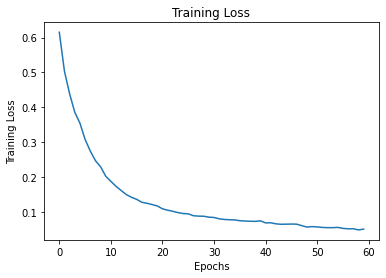

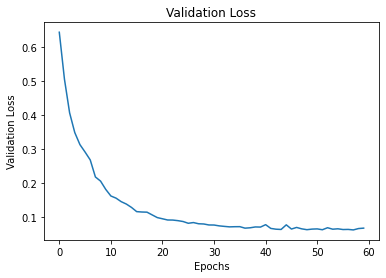

In [20]:
plt.figure()
plt.plot(params['train_loss'])
plt.title('Training Loss')
plt.ylabel('Training Loss')
plt.xlabel('Epochs')

plt.figure()
plt.plot(params['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epochs')

In [26]:
from random import sample
def eval(model = None, device = 'cuda', test_loader = None, num_thresholds = 30, num_examples = 5, thresh = 0.5):

  # loop
  model.eval()
  tp = np.zeros(num_thresholds,)
  fp = np.zeros(num_thresholds,)
  fn = np.zeros(num_thresholds,)
  tn = np.zeros(num_thresholds,)
  th = None

  # initiate vector for random indices to plot
  idx = sample(list(np.arange(len(test_loader))),num_examples)
  ctr = 0

  # initiate plot for image
  plt.figure(figsize=(20,20))

  for i,(x,y) in enumerate(test_loader):
    p = model(x.squeeze().to('cuda').unsqueeze(dim=0))
    cm = conf_matrix(y.to('cuda'),p,num_thresholds=num_thresholds)
    tp = tp + cm['TP']
    fp = fp + cm['FP']
    fn = fn + cm['FN']
    tn = tn + cm['TN']
    th = cm['th']

    # plot if i in idx
    if i in idx:
      plt.subplot(num_examples,3,3*ctr+1)
      plt.imshow(x.squeeze().permute(1,2,0))
      plt.title(f'Ex{ctr+1} Input')

      plt.subplot(num_examples,3,3*ctr+2)
      plt.imshow(y.squeeze())
      plt.title(f'Ex{ctr+1} GT')

      plt.subplot(num_examples,3,3*ctr+3)
      plt.imshow(p.squeeze().detach().cpu().numpy()>thresh)
      plt.title(f'Ex{ctr+1} Pred')

      ctr=ctr+1

  k,AUC = roc_plot(cm)

  print(f'AUC for test: {AUC}')

  # Plot the F1 curve
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)

  plt.figure()
  plt.title('F1 Score')
  plt.xlabel('Threshold Value')
  plt.ylabel('F1 Score')
  plt.plot(th,2*precision*recall/(precision+recall))

  return cm

  


AUC for test: 0.9983258189448279


"\n# Analysis\nidx = 13\n_th = cm['th'][idx]\n_tp = cm['TP'][idx]\n_fp = cm['FP'][idx]\n_fn = cm['FN'][idx]\n\n# Use the threshold\nprint(f'Best threshold:{_th}')\n\n# Print the F1\nprecision = _tp/(_tp+_fp)\nrecall = _tp/(_tp+_fn)\n\nprint(f'F1: {2*precision*recall/(precision+recall)}')\n\n# Print dice score\nprint(f'Dice: {2*_tp/(2*_tp+_fn+_fp)}')\n"

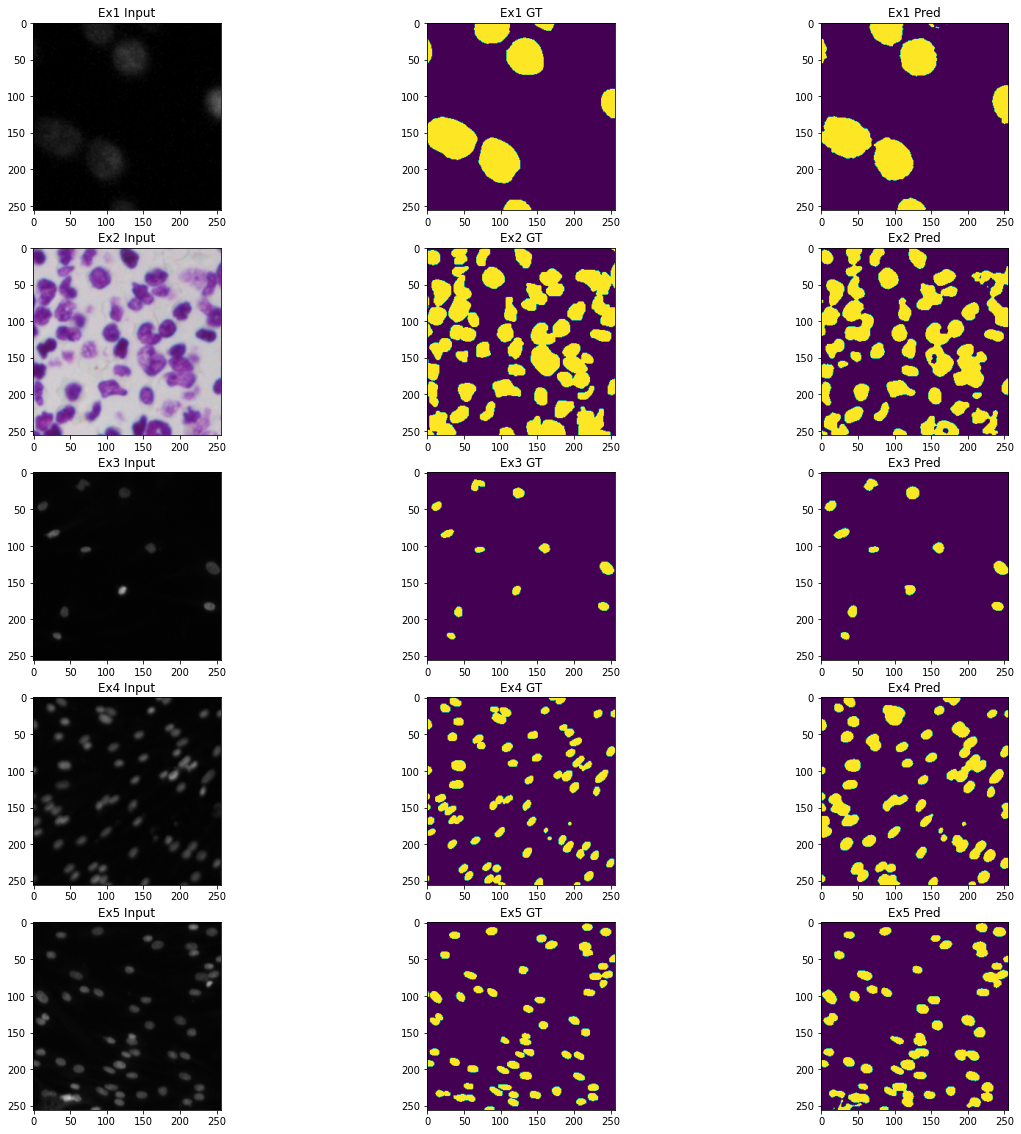

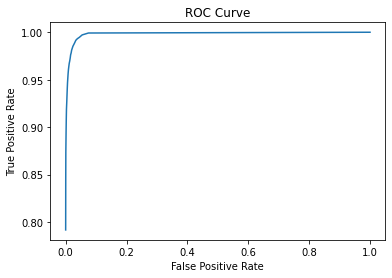

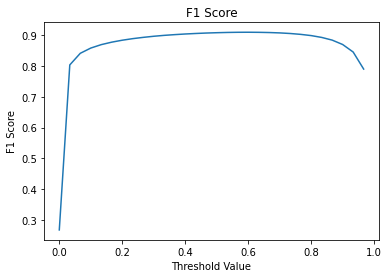

In [38]:

cm1 = eval(model,'cuda',test_loader,30,5,0.5)

'''
# Analysis
idx = 13
_th = cm['th'][idx]
_tp = cm['TP'][idx]
_fp = cm['FP'][idx]
_fn = cm['FN'][idx]

# Use the threshold
print(f'Best threshold:{_th}')

# Print the F1
precision = _tp/(_tp+_fp)
recall = _tp/(_tp+_fn)

print(f'F1: {2*precision*recall/(precision+recall)}')

# Print dice score
print(f'Dice: {2*_tp/(2*_tp+_fn+_fp)}')
'''

## Run training (Bilinear Upsampling)


In [30]:

device = 'cuda'
model2 = UNet(in_channels = 4, num_labels = 1, base_num_filters=16, mode = 'bilinear').to(device)
lr = 1e-4
optimizer = optim.Adam(model2.parameters(),lr=lr)
torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=2)
num_epochs = 60
batch_size = 50


params = train(model = model2, device = 'cuda', optimizer = optimizer, train_loader= train_loader, val_loader = val_loader, num_epochs = num_epochs,batch_size = batch_size, lr = lr)


------------epoch1--------------


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


===> Epoch 1: Train Loss -> 0.6850841119885445
===> Epoch 1: Validation Loss -> 0.7367248279707772
------------epoch2--------------


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


===> Epoch 2: Train Loss -> 0.6122806643446287
===> Epoch 2: Validation Loss -> 0.7098245876176017
------------epoch3--------------


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


===> Epoch 3: Train Loss -> 0.5658149446050326
===> Epoch 3: Validation Loss -> 0.5742258684975761
------------epoch4--------------


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


===> Epoch 4: Train Loss -> 0.49585065866510075
===> Epoch 4: Validation Loss -> 0.5014029528413501
------------epoch5--------------


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


===> Epoch 5: Train Loss -> 0.4264735206961632
===> Epoch 5: Validation Loss -> 0.4269231855869293
------------epoch6--------------


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


===> Epoch 6: Train Loss -> 0.3874048553407192
===> Epoch 6: Validation Loss -> 0.38768479228019714
------------epoch7--------------


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


===> Epoch 7: Train Loss -> 0.34822307775417966
===> Epoch 7: Validation Loss -> 0.33777585199901033
------------epoch8--------------


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


===> Epoch 8: Train Loss -> 0.32311439017454785
===> Epoch 8: Validation Loss -> 0.32249167561531067
------------epoch9--------------


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


===> Epoch 9: Train Loss -> 0.2986632299919923
===> Epoch 9: Validation Loss -> 0.30587419867515564
------------epoch10--------------


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


===> Epoch 10: Train Loss -> 0.27121023709575337
===> Epoch 10: Validation Loss -> 0.2706117331981659
------------epoch11--------------


100%|██████████| 24/24 [00:28<00:00,  1.20s/it]


===> Epoch 11: Train Loss -> 0.25226992679138976
===> Epoch 11: Validation Loss -> 0.264428762452943
------------epoch12--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 12: Train Loss -> 0.23409846797585487
===> Epoch 12: Validation Loss -> 0.21597451184477126
------------epoch13--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 13: Train Loss -> 0.21791701825956503
===> Epoch 13: Validation Loss -> 0.21767538573060716
------------epoch14--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 14: Train Loss -> 0.20793205065031847
===> Epoch 14: Validation Loss -> 0.22359423339366913
------------epoch15--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 15: Train Loss -> 0.19078989575306574
===> Epoch 15: Validation Loss -> 0.18651472457817622
------------epoch16--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 16: Train Loss -> 0.17540431208908558
===> Epoch 16: Validation Loss -> 0.1624470693724496
------------epoch17--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 17: Train Loss -> 0.16457072707513967
===> Epoch 17: Validation Loss -> 0.16717202535697392
------------epoch18--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 18: Train Loss -> 0.15915621755023798
===> Epoch 18: Validation Loss -> 0.1448806652000972
------------epoch19--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 19: Train Loss -> 0.14489474271734556
===> Epoch 19: Validation Loss -> 0.13473389404160635
------------epoch20--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 20: Train Loss -> 0.13842523470520973
===> Epoch 20: Validation Loss -> 0.12581546711070196
------------epoch21--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 21: Train Loss -> 0.13202606638272604
===> Epoch 21: Validation Loss -> 0.12258323282003403
------------epoch22--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 22: Train Loss -> 0.12649417761713266
===> Epoch 22: Validation Loss -> 0.11231174107108798
------------epoch23--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 23: Train Loss -> 0.11927386901030938
===> Epoch 23: Validation Loss -> 0.11179545095988683
------------epoch24--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 24: Train Loss -> 0.12011643995841344
===> Epoch 24: Validation Loss -> 0.10758570900985173
------------epoch25--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 25: Train Loss -> 0.11298034650584061
===> Epoch 25: Validation Loss -> 0.10657813825777598
------------epoch26--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 26: Train Loss -> 0.11070351240535577
===> Epoch 26: Validation Loss -> 0.10477545325245176
------------epoch27--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 27: Train Loss -> 0.10827853282292683
===> Epoch 27: Validation Loss -> 0.0976266839674541
------------epoch28--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 28: Train Loss -> 0.10438956165065368
===> Epoch 28: Validation Loss -> 0.09323824197053909
------------epoch29--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 29: Train Loss -> 0.10303902781258027
===> Epoch 29: Validation Loss -> 0.08907779412610191
------------epoch30--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 30: Train Loss -> 0.10387840215116739
===> Epoch 30: Validation Loss -> 0.10125857378755297
------------epoch31--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 31: Train Loss -> 0.09671231421331565
===> Epoch 31: Validation Loss -> 0.0877447532755988
------------epoch32--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 32: Train Loss -> 0.09575458150357008
===> Epoch 32: Validation Loss -> 0.0898485683969089
------------epoch33--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 33: Train Loss -> 0.09437912609428167
===> Epoch 33: Validation Loss -> 0.0869019159248897
------------epoch34--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 34: Train Loss -> 0.09180147914836805
===> Epoch 34: Validation Loss -> 0.08846944889851979
------------epoch35--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 35: Train Loss -> 0.08686552972843249
===> Epoch 35: Validation Loss -> 0.08004631527832576
------------epoch36--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 36: Train Loss -> 0.08486895511547725
===> Epoch 36: Validation Loss -> 0.0863383130303451
------------epoch37--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 37: Train Loss -> 0.09200604259967804
===> Epoch 37: Validation Loss -> 0.26530581286975313
------------epoch38--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 38: Train Loss -> 0.08818171825259924
===> Epoch 38: Validation Loss -> 0.08308271212237221
------------epoch39--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 39: Train Loss -> 0.08563287276774645
===> Epoch 39: Validation Loss -> 0.07979436431612287
------------epoch40--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 40: Train Loss -> 0.08391697611659765
===> Epoch 40: Validation Loss -> 0.07319593376346997
------------epoch41--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 41: Train Loss -> 0.07984888926148415
===> Epoch 41: Validation Loss -> 0.074005162609475
------------epoch42--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 42: Train Loss -> 0.08095036260783672
===> Epoch 42: Validation Loss -> 0.07619957466210638
------------epoch43--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 43: Train Loss -> 0.08235937527691324
===> Epoch 43: Validation Loss -> 0.07900820193546158
------------epoch44--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 44: Train Loss -> 0.08082725619897246
===> Epoch 44: Validation Loss -> 0.07568210735917091
------------epoch45--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 45: Train Loss -> 0.07592789176851511
===> Epoch 45: Validation Loss -> 0.069044398942164
------------epoch46--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 46: Train Loss -> 0.07465791795402765
===> Epoch 46: Validation Loss -> 0.07357741253716606
------------epoch47--------------


100%|██████████| 24/24 [00:27<00:00,  1.17s/it]


===> Epoch 47: Train Loss -> 0.07471689814701676
===> Epoch 47: Validation Loss -> 0.06769212867532458
------------epoch48--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 48: Train Loss -> 0.07135310117155313
===> Epoch 48: Validation Loss -> 0.0682627521455288
------------epoch49--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 49: Train Loss -> 0.07151994435116649
===> Epoch 49: Validation Loss -> 0.06994422205856868
------------epoch50--------------


100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


===> Epoch 50: Train Loss -> 0.07180283513541023
===> Epoch 50: Validation Loss -> 0.07052037971360343
------------epoch51--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 51: Train Loss -> 0.07157413894310594
===> Epoch 51: Validation Loss -> 0.06366886358175959
------------epoch52--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 52: Train Loss -> 0.06855215442677338
===> Epoch 52: Validation Loss -> 0.07089503056236676
------------epoch53--------------


100%|██████████| 24/24 [00:28<00:00,  1.18s/it]


===> Epoch 53: Train Loss -> 0.07176089053973556
===> Epoch 53: Validation Loss -> 0.06957497873476573
------------epoch54--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 54: Train Loss -> 0.0678494768217206
===> Epoch 54: Validation Loss -> 0.06460801937750407
------------epoch55--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 55: Train Loss -> 0.06655032187700272
===> Epoch 55: Validation Loss -> 0.06443840478147779
------------epoch56--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 56: Train Loss -> 0.06754150024304788
===> Epoch 56: Validation Loss -> 0.07038244072880064
------------epoch57--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 57: Train Loss -> 0.06720811718453963
===> Epoch 57: Validation Loss -> 0.0630104983491557
------------epoch58--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 58: Train Loss -> 0.06702398229390383
===> Epoch 58: Validation Loss -> 0.06984642733420644
------------epoch59--------------


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


===> Epoch 59: Train Loss -> 0.064780259039253
===> Epoch 59: Validation Loss -> 0.06293971570474761
------------epoch60--------------


100%|██████████| 24/24 [00:28<00:00,  1.18s/it]


===> Epoch 60: Train Loss -> 0.06400916911661625
===> Epoch 60: Validation Loss -> 0.06466664906058993


### Evaluation of Bilinear upsampling

Text(0.5, 0, 'Epochs')

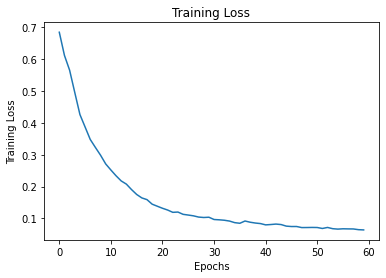

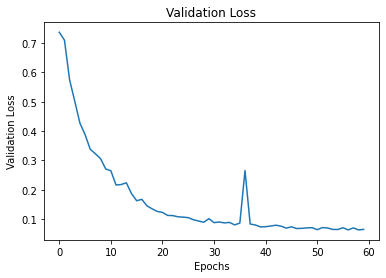

In [31]:
plt.figure()
plt.plot(params['train_loss'])
plt.title('Training Loss')
plt.ylabel('Training Loss')
plt.xlabel('Epochs')

plt.figure()
plt.plot(params['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epochs')

AUC for test: 0.9982373439296737


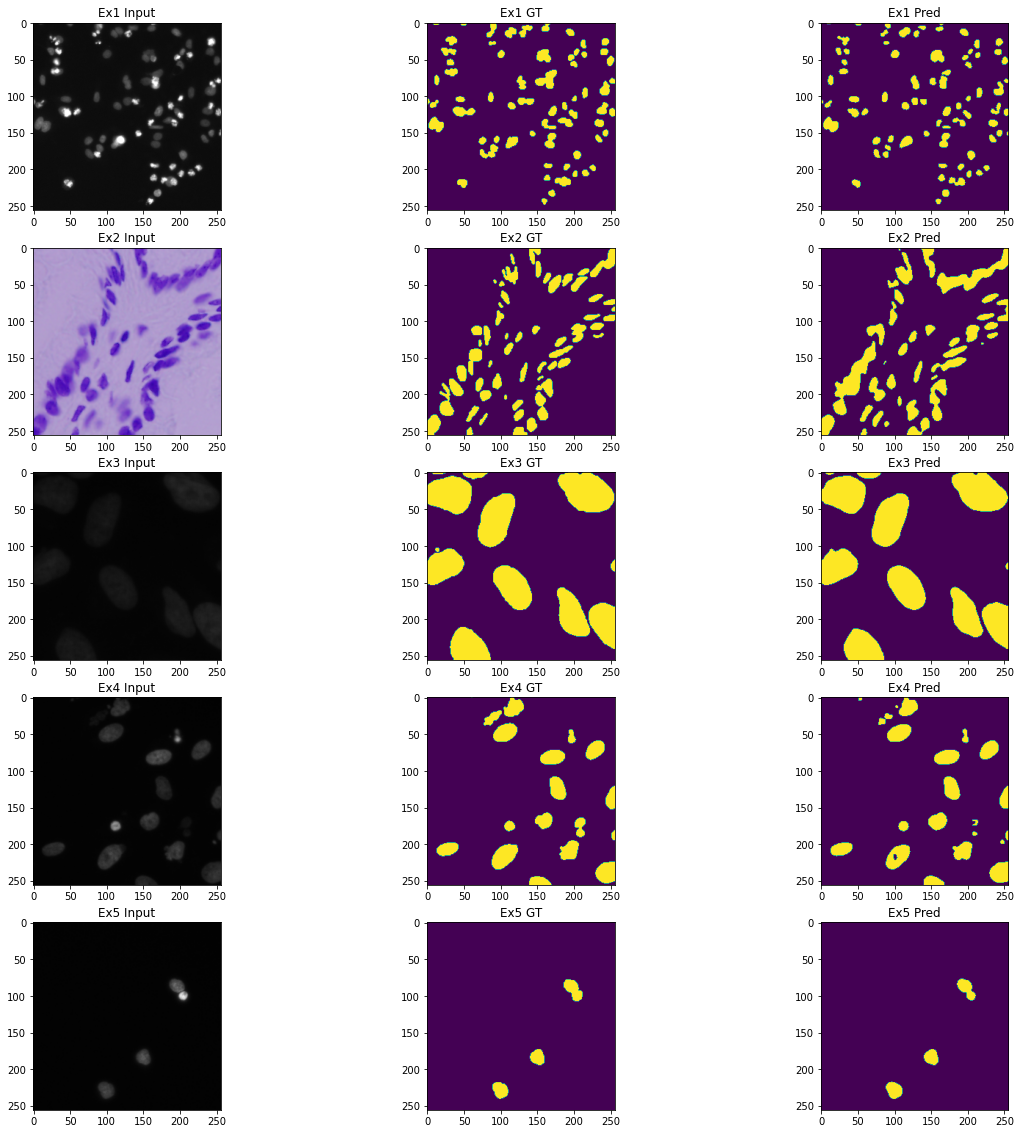

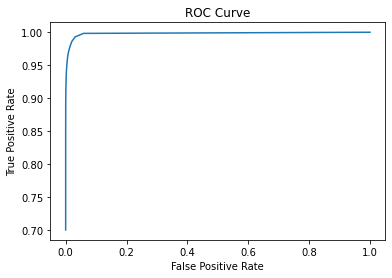

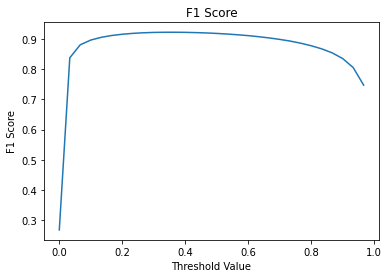

In [37]:
cm2 = eval(model2,'cuda',test_loader,30,5)

## Run training (Bicubic Upsampling)


In [33]:

device = 'cuda'
model3 = UNet(in_channels = 4, num_labels = 1, base_num_filters=16, mode = 'bicubic').to(device)
lr = 1e-4
optimizer = optim.Adam(model3.parameters(),lr=lr)
torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=2)
num_epochs = 60
batch_size = 50


params = train(model = model3, device = 'cuda', optimizer = optimizer, train_loader= train_loader, val_loader = val_loader, num_epochs = num_epochs,batch_size = batch_size, lr = lr)


------------epoch1--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 1: Train Loss -> 0.5947308018803596
===> Epoch 1: Validation Loss -> 0.69605781350817
------------epoch2--------------


100%|██████████| 24/24 [00:30<00:00,  1.29s/it]


===> Epoch 2: Train Loss -> 0.478445070485274
===> Epoch 2: Validation Loss -> 0.5815649032592773
------------epoch3--------------


100%|██████████| 24/24 [00:30<00:00,  1.26s/it]


===> Epoch 3: Train Loss -> 0.38629866143067676
===> Epoch 3: Validation Loss -> 0.36057133759771076
------------epoch4--------------


100%|██████████| 24/24 [00:30<00:00,  1.25s/it]


===> Epoch 4: Train Loss -> 0.32283547644813854
===> Epoch 4: Validation Loss -> 0.30531069210597445
------------epoch5--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 5: Train Loss -> 0.28555139278372127
===> Epoch 5: Validation Loss -> 0.24480559996196202
------------epoch6--------------


100%|██████████| 24/24 [00:30<00:00,  1.28s/it]


===> Epoch 6: Train Loss -> 0.2446907398601373
===> Epoch 6: Validation Loss -> 0.21938003599643707
------------epoch7--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 7: Train Loss -> 0.22212529244522253
===> Epoch 7: Validation Loss -> 0.19518630419458663
------------epoch8--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 8: Train Loss -> 0.20491415075957775
===> Epoch 8: Validation Loss -> 0.17690029527459825
------------epoch9--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 9: Train Loss -> 0.185014138619105
===> Epoch 9: Validation Loss -> 0.17190816359860556
------------epoch10--------------


100%|██████████| 24/24 [00:30<00:00,  1.26s/it]


===> Epoch 10: Train Loss -> 0.170449772849679
===> Epoch 10: Validation Loss -> 0.17552210603441512
------------epoch11--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 11: Train Loss -> 0.15721691772341728
===> Epoch 11: Validation Loss -> 0.1470746025443077
------------epoch12--------------


100%|██████████| 24/24 [00:30<00:00,  1.26s/it]


===> Epoch 12: Train Loss -> 0.1478212165335814
===> Epoch 12: Validation Loss -> 0.13025213032960892
------------epoch13--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 13: Train Loss -> 0.1395730779816707
===> Epoch 13: Validation Loss -> 0.11333668338400978
------------epoch14--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 14: Train Loss -> 0.13654464452217022
===> Epoch 14: Validation Loss -> 0.11282387375831604
------------epoch15--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 15: Train Loss -> 0.1301771899064382
===> Epoch 15: Validation Loss -> 0.1141547081725938
------------epoch16--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 16: Train Loss -> 0.12136926408857107
===> Epoch 16: Validation Loss -> 0.09897105608667646
------------epoch17--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 17: Train Loss -> 0.11225010485698779
===> Epoch 17: Validation Loss -> 0.09371633295501981
------------epoch18--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 18: Train Loss -> 0.11268412849555413
===> Epoch 18: Validation Loss -> 0.11654699593782425
------------epoch19--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 19: Train Loss -> 0.10694625321775675
===> Epoch 19: Validation Loss -> 0.08901157123701912
------------epoch20--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 20: Train Loss -> 0.10109648201614618
===> Epoch 20: Validation Loss -> 0.0845813410622733
------------epoch21--------------


100%|██████████| 24/24 [00:30<00:00,  1.26s/it]


===> Epoch 21: Train Loss -> 0.0994321849818031
===> Epoch 21: Validation Loss -> 0.08143173583916255
------------epoch22--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 22: Train Loss -> 0.0948123096798857
===> Epoch 22: Validation Loss -> 0.08186253266675132
------------epoch23--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 23: Train Loss -> 0.09294697362929583
===> Epoch 23: Validation Loss -> 0.07658142117517334
------------epoch24--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 24: Train Loss -> 0.0914882468059659
===> Epoch 24: Validation Loss -> 0.07891074674470085
------------epoch25--------------


100%|██████████| 24/24 [00:30<00:00,  1.26s/it]


===> Epoch 25: Train Loss -> 0.0895858829220136
===> Epoch 25: Validation Loss -> 0.07526624043072973
------------epoch26--------------


100%|██████████| 24/24 [00:30<00:00,  1.28s/it]


===> Epoch 26: Train Loss -> 0.0884289457462728
===> Epoch 26: Validation Loss -> 0.07198176745857511
------------epoch27--------------


100%|██████████| 24/24 [00:30<00:00,  1.29s/it]


===> Epoch 27: Train Loss -> 0.08422166109085083
===> Epoch 27: Validation Loss -> 0.07332155906728335
------------epoch28--------------


100%|██████████| 24/24 [00:30<00:00,  1.28s/it]


===> Epoch 28: Train Loss -> 0.08369902676592271
===> Epoch 28: Validation Loss -> 0.06992740663034576
------------epoch29--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 29: Train Loss -> 0.08204105651626985
===> Epoch 29: Validation Loss -> 0.07007400904382978
------------epoch30--------------


100%|██████████| 24/24 [00:30<00:00,  1.28s/it]


===> Epoch 30: Train Loss -> 0.08157525832454364
===> Epoch 30: Validation Loss -> 0.06975072409425463
------------epoch31--------------


100%|██████████| 24/24 [00:30<00:00,  1.28s/it]


===> Epoch 31: Train Loss -> 0.07869656026984255
===> Epoch 31: Validation Loss -> 0.06850486780915942
------------epoch32--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 32: Train Loss -> 0.07766525261104107
===> Epoch 32: Validation Loss -> 0.06719848939350673
------------epoch33--------------


100%|██████████| 24/24 [00:30<00:00,  1.28s/it]


===> Epoch 33: Train Loss -> 0.07950576798369487
===> Epoch 33: Validation Loss -> 0.06965907290577888
------------epoch34--------------


100%|██████████| 24/24 [00:30<00:00,  1.28s/it]


===> Epoch 34: Train Loss -> 0.0756652959001561
===> Epoch 34: Validation Loss -> 0.06533874571323395
------------epoch35--------------


100%|██████████| 24/24 [00:30<00:00,  1.28s/it]


===> Epoch 35: Train Loss -> 0.07502291553343336
===> Epoch 35: Validation Loss -> 0.06490080484322139
------------epoch36--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 36: Train Loss -> 0.07497067609801888
===> Epoch 36: Validation Loss -> 0.06757314237100738
------------epoch37--------------


100%|██████████| 24/24 [00:30<00:00,  1.26s/it]


===> Epoch 37: Train Loss -> 0.07258661137893796
===> Epoch 37: Validation Loss -> 0.06668101730091232
------------epoch38--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 38: Train Loss -> 0.07163043273612857
===> Epoch 38: Validation Loss -> 0.06387277586119515
------------epoch39--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 39: Train Loss -> 0.07008011359721422
===> Epoch 39: Validation Loss -> 0.0625435821712017
------------epoch40--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 40: Train Loss -> 0.0688257091678679
===> Epoch 40: Validation Loss -> 0.06264559232762881
------------epoch41--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 41: Train Loss -> 0.067582200281322
===> Epoch 41: Validation Loss -> 0.064972102109875
------------epoch42--------------


100%|██████████| 24/24 [00:30<00:00,  1.28s/it]


===> Epoch 42: Train Loss -> 0.06612489962329467
===> Epoch 42: Validation Loss -> 0.06470822117158345
------------epoch43--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 43: Train Loss -> 0.06510069236780207
===> Epoch 43: Validation Loss -> 0.06194438732096127
------------epoch44--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 44: Train Loss -> 0.0653048896541198
===> Epoch 44: Validation Loss -> 0.062156899699143
------------epoch45--------------


100%|██████████| 24/24 [00:30<00:00,  1.26s/it]


===> Epoch 45: Train Loss -> 0.0646563235980769
===> Epoch 45: Validation Loss -> 0.06380203366279602
------------epoch46--------------


100%|██████████| 24/24 [00:30<00:00,  1.26s/it]


===> Epoch 46: Train Loss -> 0.07148203269268076
===> Epoch 46: Validation Loss -> 0.06766722830278533
------------epoch47--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 47: Train Loss -> 0.06990205108498533
===> Epoch 47: Validation Loss -> 0.06600224865334374
------------epoch48--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 48: Train Loss -> 0.06526083623369534
===> Epoch 48: Validation Loss -> 0.060564328517232625
------------epoch49--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 49: Train Loss -> 0.061754176703592144
===> Epoch 49: Validation Loss -> 0.06029966686453138
------------epoch50--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 50: Train Loss -> 0.06304740471144517
===> Epoch 50: Validation Loss -> 0.06491619401744433
------------epoch51--------------


100%|██████████| 24/24 [00:30<00:00,  1.28s/it]


===> Epoch 51: Train Loss -> 0.06069516142209371
===> Epoch 51: Validation Loss -> 0.06211068747299058
------------epoch52--------------


100%|██████████| 24/24 [00:30<00:00,  1.28s/it]


===> Epoch 52: Train Loss -> 0.06222698356335362
===> Epoch 52: Validation Loss -> 0.06605151508535657
------------epoch53--------------


100%|██████████| 24/24 [00:30<00:00,  1.28s/it]


===> Epoch 53: Train Loss -> 0.061208675149828196
===> Epoch 53: Validation Loss -> 0.06771950583372797
------------epoch54--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 54: Train Loss -> 0.060986125841736794
===> Epoch 54: Validation Loss -> 0.06035880797675678
------------epoch55--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 55: Train Loss -> 0.05864866574605306
===> Epoch 55: Validation Loss -> 0.060204735291855674
------------epoch56--------------


100%|██████████| 24/24 [00:30<00:00,  1.28s/it]


===> Epoch 56: Train Loss -> 0.05658017393822471
===> Epoch 56: Validation Loss -> 0.06093287308301244
------------epoch57--------------


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


===> Epoch 57: Train Loss -> 0.05682598908121387
===> Epoch 57: Validation Loss -> 0.06096769869327545
------------epoch58--------------


100%|██████████| 24/24 [00:30<00:00,  1.28s/it]


===> Epoch 58: Train Loss -> 0.05684437587236365
===> Epoch 58: Validation Loss -> 0.05936984717845917
------------epoch59--------------


100%|██████████| 24/24 [00:30<00:00,  1.28s/it]


===> Epoch 59: Train Loss -> 0.053878456043700375
===> Epoch 59: Validation Loss -> 0.0601351654955319
------------epoch60--------------


100%|██████████| 24/24 [00:30<00:00,  1.28s/it]


===> Epoch 60: Train Loss -> 0.053876537984857954
===> Epoch 60: Validation Loss -> 0.06307299594794001


### Evaluation of Bicubic upsampling

Text(0.5, 0, 'Epochs')

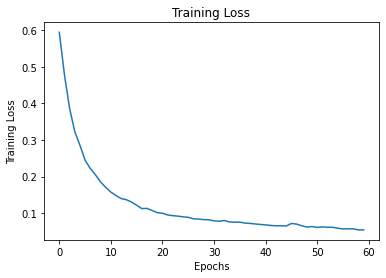

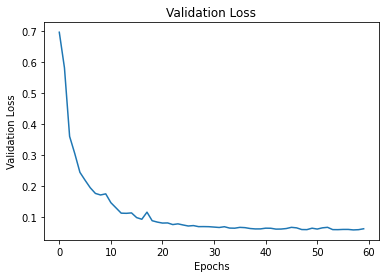

In [34]:
plt.figure()
plt.plot(params['train_loss'])
plt.title('Training Loss')
plt.ylabel('Training Loss')
plt.xlabel('Epochs')

plt.figure()
plt.plot(params['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epochs')

AUC for test: 0.9988486599034672


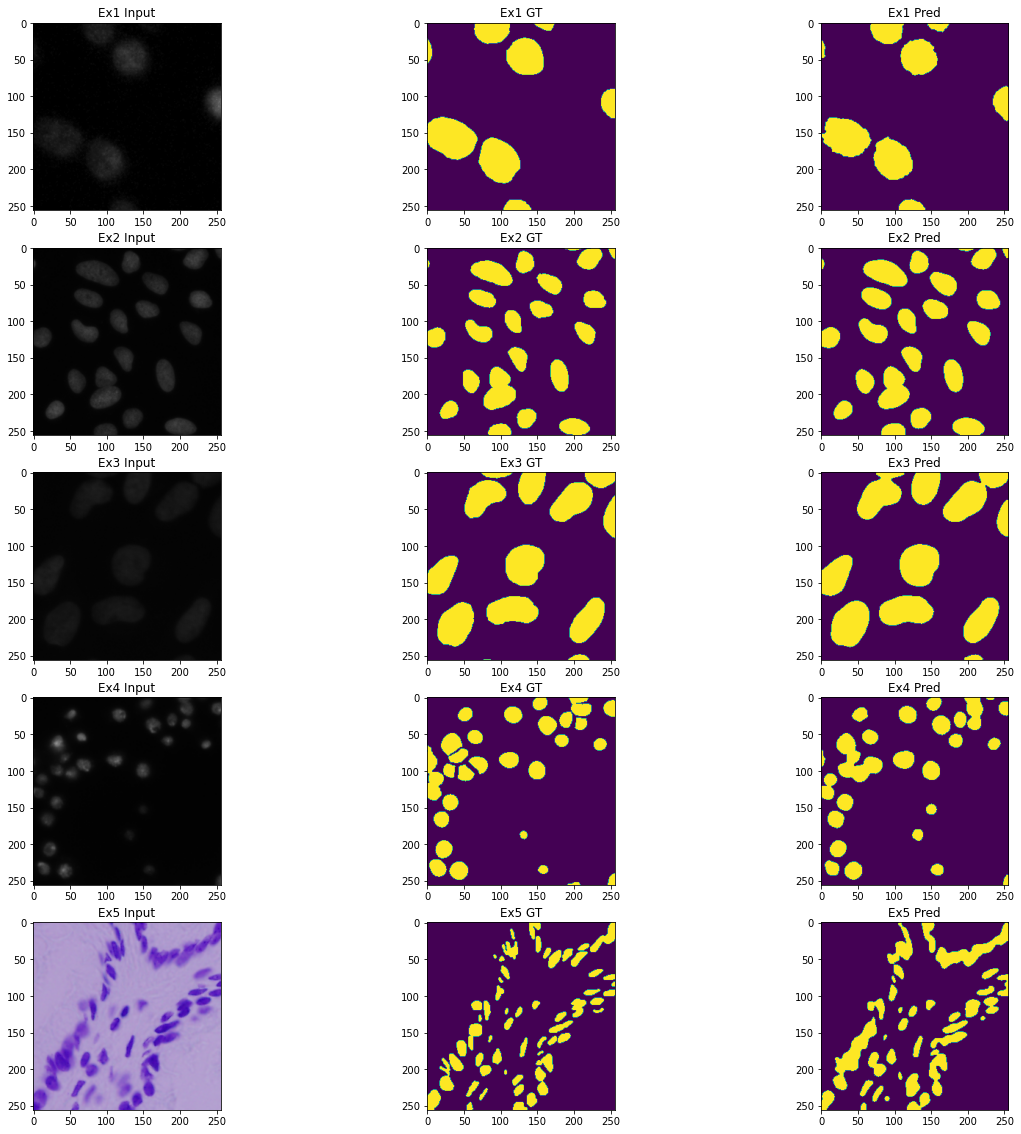

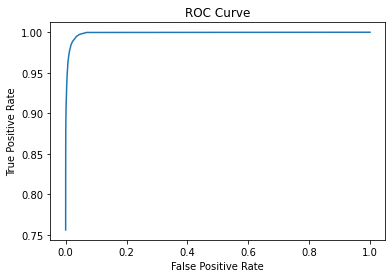

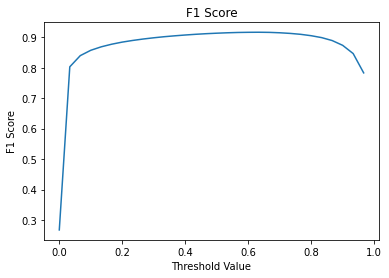

In [36]:
cm3 = eval(model3,'cuda',test_loader,30,5)